In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np

price_df = pd.read_csv("/content/training_data.csv", parse_dates=['date'])
sent_df = pd.read_csv("/content/sentiment_data.csv", parse_dates=['date'])


# Convert to datetime
price_df["date"] = pd.to_datetime(price_df["date"])
sent_df["date"] = pd.to_datetime(sent_df["date"])

# Sort both by date
price_df = price_df.sort_values("date")
sent_df = sent_df.sort_values("date")

# Shift sentiment by one day backward to avoid lookahead bias
sent_df["sentiment_score"] = sent_df["sentiment_score"].shift(1)

# Merge properly on date
merged_df = pd.merge(price_df, sent_df, on="date", how="left")

# Fill missing sentiment (before 2012 or missing days) with 0
merged_df = merged_df.dropna(subset=["sentiment_score"])

# Sort again for safety
merged_df = merged_df.sort_values("date").reset_index(drop=True)

# Inspect sample
print(merged_df.head(15))
print(merged_df.tail(15))

         date  price_usd_per_mmbtu        source  sentiment_score
0  2012-12-10                 3.35  FRED:DHHNGSP         0.045655
1  2012-12-11                 3.39  FRED:DHHNGSP         0.584642
2  2012-12-12                 3.33  FRED:DHHNGSP         0.403724
3  2012-12-13                 3.27  FRED:DHHNGSP         0.553235
4  2012-12-14                 3.15  FRED:DHHNGSP         0.086875
5  2012-12-17                 3.20  FRED:DHHNGSP         0.425910
6  2012-12-18                 3.29  FRED:DHHNGSP         0.267380
7  2012-12-19                 3.25  FRED:DHHNGSP         0.344278
8  2012-12-20                 3.35  FRED:DHHNGSP         0.574574
9  2012-12-21                 3.42  FRED:DHHNGSP         0.205881
10 2012-12-24                 3.30  FRED:DHHNGSP        -0.191383
11 2012-12-27                 3.31  FRED:DHHNGSP         0.058812
12 2012-12-28                 3.40  FRED:DHHNGSP        -0.017793
13 2012-12-31                 3.43  FRED:DHHNGSP        -0.012983
14 2013-01

In [ ]:
# data cleaning

df = merged_df.sort_values("date").reset_index(drop=True)

# Drop rows with missing price or sentiment
df = df.dropna(subset=["price_usd_per_mmbtu", "sentiment_score"]).reset_index(drop=True)

# lagged and exponencial weighted means
df['price_lag7'] = df['price_usd_per_mmbtu'].shift(7)
df['price_lag30'] = df['price_usd_per_mmbtu'].shift(30)
df['rolling_mean_7'] = df['price_usd_per_mmbtu'].ewm(span=7).mean()
df['rolling_mean_30'] = df['price_usd_per_mmbtu'].ewm(span=30).mean()
df['sentiment_rolling_7'] = df['sentiment_score'].ewm(span=7).mean()
df['sentiment_rolling_30'] = df['sentiment_score'].ewm(span=30).mean()


# Drop initial rows with NaNs from shift/rolling
df = df.dropna().reset_index(drop=True)


# Create target (next-day price)
df['target'] = df['price_usd_per_mmbtu'].shift(-1)
df = df.dropna(subset=['target']).reset_index(drop=True)
df

,date,price_usd_per_mmbtu,source,sentiment_score,price_lag7,price_lag30,rolling_mean_7,rolling_mean_30,sentiment_rolling_7,sentiment_rolling_30,target
0,2013-01-29,3.14,FRED:DHHNGSP,0.409035,3.44,3.35,3.346531,3.347550,0.071224,0.066658,3.24
1,2013-01-30,3.24,FRED:DHHNGSP,0.367966,3.54,3.39,3.319896,3.339680,0.145417,0.088707,3.33
2,2013-01-31,3.33,FRED:DHHNGSP,0.450467,3.63,3.33,3.322422,3.338978,0.221685,0.114952,3.34
3,2013-02-01,3.34,FRED:DHHNGSP,0.137786,3.53,3.27,3.326817,3.339051,0.200709,0.116595,3.27
4,2013-02-04,3.27,FRED:DHHNGSP,0.253619,3.56,3.15,3.312612,3.334118,0.213937,0.126384,3.34
...,...,...,...,...,...,...,...,...,...,...,...
1734,2019-12-20,2.27,FRED:DHHNGSP,0.242348,2.28,2.82,2.271009,2.380370,0.156363,0.070098,2.17
1735,2019-12-23,2.17,FRED:DHHNGSP,-0.340349,2.28,2.84,2.245757,2.366798,0.032185,0.043617,2.11
1736,2019-12-24,2.11,FRED:DHHNGSP,-0.228993,2.28,2.87,2.211818,2.350230,-0.033109,0.026029,1.75
1737,2019-12-27,1.75,FRED:DHHNGSP,-0.195998,2.34,2.72,2.096363,2.311506,-0.073832,0.011705,2.06


In [ ]:
# Split after features are computed
split_idx = int(len(merged_df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

feature_cols = ["price_lag7", "price_lag30", "rolling_mean_7",
                "rolling_mean_30", "sentiment_score", "sentiment_rolling_7", "sentiment_rolling_30"]

X_train = train_df[feature_cols]
y_train = train_df['target']

X_test = test_df[feature_cols]
y_test = test_df['target']

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (1441, 7) (1441,)
Test: (298, 7) (298,)


In [ ]:
print("NaNs in X_train:", X_train.isna().sum().sum())
print("NaNs in y_train:", y_train.isna().sum())
print("NaNs in X_test:", X_test.isna().sum().sum())
print("NaNs in y_test:", y_test.isna().sum())

NaNs in X_train: 0
NaNs in y_train: 0
NaNs in X_test: 0
NaNs in y_test: 0


In [ ]:
# training xgboost
import xgboost as xgb

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)


In [ ]:
# rondom cv search for hyperparameter optimization
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)

param_grid = {
    'n_estimators': [200, 400, 600, 800, 1000],
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.5, 1],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 2, 3]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,                # number of random combinations to test
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.7, 'reg_lambda': 3, 'reg_alpha': 0.1, 'n_estimators': 1000, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}


In [ ]:
from xgboost import XGBRegressor
# model based on best hyperparameters
best_params = random_search.best_params_

final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
import math
# model evaluation
y_pred = final_model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.4f}, R²: {r2:.4f}, RMSE: {math.sqrt(mse):.4f}")


Test MSE: 0.0427, R²: 0.8852, RMSE: 0.2067


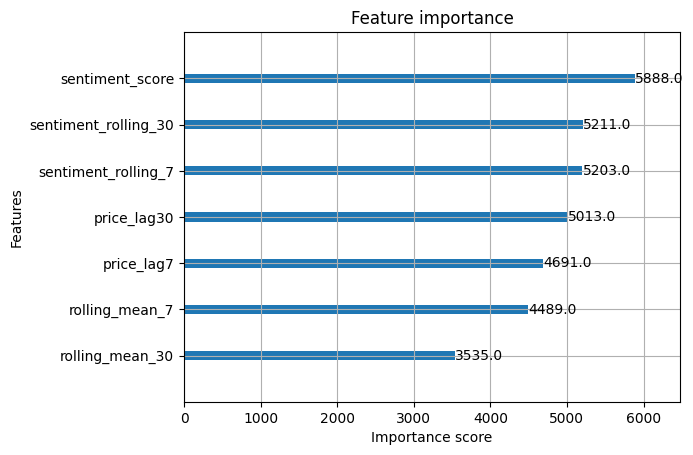

In [ ]:
import matplotlib.pyplot as plt
xgb.plot_importance(final_model)
plt.show()

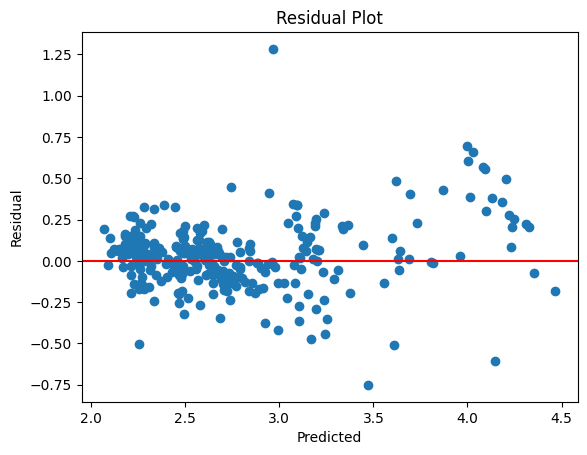

In [ ]:
# residual plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red')
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residual Plot")
plt.show()

In [ ]:
import joblib
joblib.dump(final_model, "xgb_commodity_model.pkl")

['xgb_commodity_model.pkl']

In [ ]:
# inference

In [ ]:
MODEL_PATH = "/content/xgb_commodity_model.pkl"
PRICE_DATA_PATH = "/content/training_data.csv"
SENTIMENT_DATA_PATH = "/content/sentiment_data.csv"
TEST_DATA_PATH = "/content/test-template.csv"

# Feature columns must match the training set exactly
FEATURE_COLS = ["price_lag7", "price_lag30", "rolling_mean_7", "rolling_mean_30",
                "sentiment_score", "sentiment_rolling_7", "sentiment_rolling_30"]

# Load the trained model
try:
    final_model = joblib.load(MODEL_PATH)
except FileNotFoundError:
    print(f"Error: Model file '{MODEL_PATH}' not found.")
    raise

In [ ]:
def get_historical_features(price_path, sentiment_path):
  """Loads and computes ALL historical features to find the last valid state."""

  # Load and Prepare
  price_df = pd.read_csv(price_path, parse_dates=['date'])
  sent_df = pd.read_csv(sentiment_path, parse_dates=['date'])

  price_df["date"] = pd.to_datetime(price_df["date"]).dt.normalize()
  sent_df["date"] = pd.to_datetime(sent_df["date"]).dt.normalize()

  # Sentiment Shift and Merge (as in your training code)
  sent_df['sentiment_score'] = sent_df['sentiment_score'].shift(1)
  full_df = pd.merge(price_df, sent_df, on='date', how='left')
  full_df = full_df.sort_values('date').reset_index(drop=True)

  # Fill missing sentiment with 0 (as in your training code)
  full_df['sentiment_score'] = full_df['sentiment_score'].fillna(0)

  # Compute ALL Historical Lags needed for recursive tracking (L=2 up to L=30)
  for L in range(2, 31):
      full_df[f'price_lag{L}'] = full_df['price_usd_per_mmbtu'].shift(L)

  # EWM is calculated cumulatively from the start
  full_df['rolling_mean_7'] = full_df['price_usd_per_mmbtu'].ewm(span=7).mean()
  full_df['rolling_mean_30'] = full_df['price_usd_per_mmbtu'].ewm(span=30).mean()
  full_df['sentiment_rolling_7'] = full_df['sentiment_score'].ewm(span=7).mean()
  full_df['sentiment_rolling_30'] = full_df['sentiment_score'].ewm(span=30).mean()

  # Drop initial NaNs and get the last valid row (the starting state)
  full_df = full_df.dropna(subset=FEATURE_COLS).reset_index(drop=True)

  # The last row of this generated DataFrame is the required starting state (e.g., 2019-12-31)
  last_historical_row = full_df.iloc[-1].copy()
  # return sentiment lookup for the prediction period
  return last_historical_row, sent_df.set_index('date')['sentiment_score']

In [ ]:
# --- Function for Feature Creation (Recursive EWM Logic) ---
def create_inference_features(history_row, current_date_sentiment):
    """Calculates the feature vector for the prediction date (T) using T-1 data."""

    # Lags use the last known price
    price_lag7 = history_row['price_lag6']
    price_lag30 = history_row['price_lag29']
    sentiment_score = current_date_sentiment # This is the T-1 raw sentiment

    # EWM Alpha calculation: alpha = 2 / (span + 1)
    alpha_7 = 2 / (7 + 1)
    alpha_30 = 2 / (30 + 1)

    # Price EWM update (uses the last known price)
    rolling_mean_7 = (history_row['price_usd_per_mmbtu'] * alpha_7) + \
                     (history_row['rolling_mean_7'] * (1 - alpha_7))
    rolling_mean_30 = (history_row['price_usd_per_mmbtu'] * alpha_30) + \
                     (history_row['rolling_mean_30'] * (1 - alpha_30))

    # Sentiment EWM update (uses the new T-1 raw sentiment)
    sentiment_rolling_7 = (current_date_sentiment * alpha_7) + \
                          (history_row['sentiment_rolling_7'] * (1 - alpha_7))
    sentiment_rolling_30 = (current_date_sentiment * alpha_30) + \
                          (history_row['sentiment_rolling_30'] * (1 - alpha_30))

    features = {
        'price_lag7': price_lag7, 'price_lag30': price_lag30,
        'rolling_mean_7': rolling_mean_7, 'rolling_mean_30': rolling_mean_30,
        'sentiment_score': sentiment_score, 'sentiment_rolling_7': sentiment_rolling_7, 'sentiment_rolling_30': sentiment_rolling_30
    }
    return pd.DataFrame([features])

In [ ]:
# --- Main Inference Loop ---
def run_recursive_inference(model, last_historical_row, sent_lookup, dates_to_predict):
    # Initial historical state
    last_historical_row = last_historical_row.copy()
    results = []

    for target_date_str in dates_to_predict:
        target_date = pd.to_datetime(target_date_str)

        # Determine the date required for the sentiment feature (T-1 raw sentiment)
        # This is not always T-1 calendar day due to missing trading days (weekends/holidays).
        # We need the sentiment feature that corresponds to the day *before* the prediction.

        # 1. Get the sentiment feature for the current prediction date (T).
        # T's feature is T-1's raw sentiment.
        # We search the sentiment_score column (which has the raw T-1 data) for the price date T.
        sentiment_day_raw_data = target_date - pd.Timedelta(days=1)

        # raw data lookup till t-1 if nothing then 0.0
        current_sentiment_feature = sent_lookup.get(sentiment_day_raw_data, 0.0)

        # 2. Create Features
        X_predict = create_inference_features(
            history_row=last_historical_row,
            current_date_sentiment=current_sentiment_feature
        )

        # 3. Predict Price
        predicted_price = model.predict(X_predict[FEATURE_COLS])[0]

        # 4. Store Result
        results.append({
            'id': target_date_str,
            'price_usd_per_mmbtu': predicted_price
        })

        # 5. Update History for the next prediction (Recursive Step)
        # Lagged Prices: shift down
        for L in range(30, 2, -1):
            # price_lag{L} gets the value of price_lag{L-1}
            last_historical_row[f'price_lag{L}'] = last_historical_row[f'price_lag{L-1}']

        # The current price (T-1) becomes price_lag2 for the next iteration (T)
        last_historical_row['price_lag2'] = last_historical_row['price_usd_per_mmbtu']

        # New Price: the prediction becomes the new 'historical' price for the next iteration
        last_historical_row['price_usd_per_mmbtu'] = predicted_price

        # EWMs and Sentiment: update using the newly calculated values
        last_historical_row['rolling_mean_7'] = X_predict['rolling_mean_7'].iloc[0]
        last_historical_row['rolling_mean_30'] = X_predict['rolling_mean_30'].iloc[0]
        last_historical_row['sentiment_rolling_7'] = X_predict['sentiment_rolling_7'].iloc[0]
        last_historical_row['sentiment_rolling_30'] = X_predict['sentiment_rolling_30'].iloc[0]
        last_historical_row['sentiment_score'] = current_sentiment_feature

    return pd.DataFrame(results)

In [ ]:
# execution

# Define the prediction dates from test-template.csv
try:
    test_df = pd.read_csv(TEST_DATA_PATH)
    # Extract all IDs (dates) and convert them to a list of strings
    dates_to_predict = test_df['id'].tolist()

    if not dates_to_predict:
        print("Error: Test file is empty or missing the 'id' column.")
        # Handle error or raise exception

except FileNotFoundError:
    print(f"Error: Test file '{TEST_DATA_PATH}' not found.")
    raise
except Exception as e:
    print(f"Error reading test file: {e}")
    raise

# Get the dynamic starting state and sentiment lookup
last_historical_row, sent_lookup = get_historical_features(PRICE_DATA_PATH, SENTIMENT_DATA_PATH)

print(f"Starting prediction from last known date: {last_historical_row['date'].strftime('%Y-%m-%d')}")
print(f"Last known price: {last_historical_row['price_usd_per_mmbtu']:.4f}")

# Run the iterative prediction
final_predictions = run_recursive_inference(final_model, last_historical_row, sent_lookup, dates_to_predict)
final_predictions['price_usd_per_mmbtu'] = final_predictions['price_usd_per_mmbtu'].round(2)
print("\n✅ Final Predictions completed for the test file")
final_predictions.to_csv("price_predictions.csv", index=False)
print("---------------------------------------")
print(final_predictions.to_markdown(index=False, floatfmt=".4f"))

Starting prediction from last known date: 2019-12-31
Last known price: 2.0900

✅ Final Predictions completed for the test file
---------------------------------------
| id         |   price_usd_per_mmbtu |
|:-----------|----------------------:|
| 2020-01-02 |                2.3300 |
| 2020-01-03 |                2.3700 |
| 2020-01-06 |                2.5200 |
| 2020-01-07 |                2.4100 |
| 2020-01-08 |                2.3700 |
| 2020-01-09 |                2.3500 |
| 2020-01-10 |                2.3900 |
| 2020-01-13 |                2.3100 |
| 2020-01-14 |                2.2900 |
| 2020-01-15 |                2.3100 |
| 2020-01-16 |                2.4000 |
| 2020-01-17 |                2.2800 |
| 2020-01-21 |                2.2000 |
| 2020-01-22 |                2.2600 |
| 2020-01-23 |                2.1800 |
| 2020-01-24 |                2.2500 |
| 2020-01-27 |                2.2200 |
| 2020-01-28 |                2.1800 |
| 2020-01-29 |                2.3000 |
| 2020-01-30 |